<a href="https://colab.research.google.com/github/jimmy-pink/colab-playground/blob/main/pre-trained/EfficientNetB3-FolderIconRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使用EfficientNetB3微调以解决FolderIcon二分类问题



### 问题分析
#### 背景
已在VGG16预训练模型上微调，在对2170多个folder icon预测，存在以下问题：
- 发现准确率仅为88%-91%
- 更要命的是基于VGG16训练出来的模型经常犯超低级错误，将毫不相干的图像判断为真。   

鉴于VGG16是非常老的模型，现以EfficientNetB3再训练一版，观察模型性能有无明显提升。



#### 要求

|**特性**|**说明**|
|---|---|
|更深、更窄、更复杂|EfficientNetB3 用更少参数提取更细粒度的特征，对训练数据的细节更敏感|
|训练更精细|它倾向于在微小差异中学习（如纹理、边角等视觉细节），对标签的一致性要求更高|
|参数更少，欠拟合风险更大|如果标签混乱，EfficientNet 可能“学不到明确的规律”，而不是像 VGG 一样粗暴记忆|


需要对标签重新处理，去掉模糊边界的样本，给任务规划清晰的边界。  
二分类问题：
- 是：标准的文件夹图标
- 否：
  - 使用预训练模型（如 EfficientNetB0）提取所有图标的特征向量。
  - 计算每张图与“正样本平均特征”之间的相似度（余弦距离）。
  - 选择距离最远的 N 张图像，作为“最不像文件夹”的负样本。

In [1]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

### 数据准备

In [2]:
## 转存 https://drive.google.com/drive/folders/1xwtf91GSyeIc7ohpCKsDCYv3zXgKa0sf
from google.colab import drive
drive.mount('/content/drive')

# 挂载 Google Drive
base_dir = '/content/drive/MyDrive/Google AI Studio/data/folder-icon-images/'  # Google Drive 中的图像文件夹路径
train_dir=base_dir+'is_folder'
drive_train_validate_dir = base_dir + "train_validate"

Mounted at /content/drive


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 设置数据增强
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)

# 使用 flow_from_directory 加载训练数据
# 数据增强 + 归一化
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.3  # 30% 作为验证集
)

# 训练集生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',  # 二分类用 binary，多分类用 categorical
    subset='training'  # 指定是训练集
)

# 验证集生成器
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 指定是验证集
)
print(f"找到的训练样本数: {train_generator.samples}")
print(f"找到的验证样本数: {validation_generator.samples}")
images, labels = next(train_generator)
print("图像形状:", images.shape)
print("标签形状:", labels.shape)

Found 1734 images belonging to 2 classes.
Found 742 images belonging to 2 classes.
找到的训练样本数: 1734
找到的验证样本数: 742


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


图像形状: (32, 300, 300, 3)
标签形状: (32,)


In [4]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# 获取训练集的真实标签（需确保 train_generator.classes 是整数标签 0/1）
y_train = train_generator.classes
# 计算类别权重（classes 需是 NumPy 数组）
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),  # 自动提取唯一类别（如 [0, 1]）
    y=y_train
)
# 转换为字典格式
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print("类别权重:", class_weights)

类别权重: {0: np.float64(0.8442064264849075), 1: np.float64(1.2263083451202264)}


### 建模与训练

In [5]:
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(300, 300, 3))

# 冻结前 n% 的层
freeze_until = int(len(base_model.layers) * 0.8)
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= freeze_until

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# 可选： 模型保存
import os
save_dir = '/content/drive/MyDrive/Google AI Studio/saved_models'
# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_file_save_path = f'{save_dir}/EfficientNetB3_folder_icon_shape_predict_model.h5'

In [15]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.98 and logs.get('val_loss') < 0.2 ):
            self.model.stop_training = True

callbacks = [
    ModelCheckpoint(
        model_file_save_path,
        monitor='val_accuracy',  # 监控验证准确率
        save_best_only=True,     # 只保留最佳
        mode='max'               # 取最大值
    ),
    EarlyStopping(monitor='val_loss', patience=5),
    myCallback()
]
# 训练模型
history = model.fit(train_generator,
          epochs=60,
          validation_data=validation_generator,
          class_weight=class_weights,
          verbose=1,
          callbacks=[callbacks])

Epoch 1/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.8427 - loss: 21.1080

55/55 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.8430 - loss: 21.0850 - val_accuracy: 0.8760 - val_loss: 17.3301
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.8681 - loss: 16.2318 - val_accuracy: 0.8248 - val_loss: 13.3261
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8720 - loss: 12.3407

55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 431ms/step - accuracy: 0.8718 - loss: 12.3264 - val_accuracy: 0.8976 - val_loss: 9.9921
Epoch 4/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.8795 - loss: 9.2917 - val_accuracy: 0.7898 - val_loss: 7.7869
Epoch 5/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 381ms/step - accuracy: 0.8636 - loss: 6.9765 - val_accuracy: 0.7291 - val_loss: 5.9065
Epoch 6/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.8912 - loss: 5.1963 - val_accuracy: 0.8922 - val_loss: 4.1901
Epoch 7/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.8661 - loss: 3.8908 - val_accuracy: 0.6658 - val_loss: 3.8682
Epoch 8/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.8737 - loss: 2.8623 - val_accuracy: 0.5728 - val_loss: 3.3240
Epoch 9/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - accuracy: 0.8757 - loss: 2.1369 - val_accuracy: 0.6941 - val_loss: 2.1392
Epoch 10/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 459ms/step - accuracy: 0.8652 - loss: 1.6085 - val_accuracy: 0.6

55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.8924 - loss: 0.2660 - val_accuracy: 0.9030 - val_loss: 0.3195
Epoch 28/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.8862 - loss: 0.2757 - val_accuracy: 0.8248 - val_loss: 0.4037
Epoch 29/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8818 - loss: 0.2910

55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 418ms/step - accuracy: 0.8820 - loss: 0.2907 - val_accuracy: 0.9084 - val_loss: 0.3233
Epoch 30/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 413ms/step - accuracy: 0.9026 - loss: 0.2610 - val_accuracy: 0.7305 - val_loss: 0.7235
Epoch 31/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.8885 - loss: 0.2530 - val_accuracy: 0.7588 - val_loss: 0.5773
Epoch 32/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.8893 - loss: 0.2682 - val_accuracy: 0.6685 - val_loss: 0.9409
Epoch 33/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.9085 - loss: 0.2409 - val_accuracy: 0.5863 - val_loss: 1.2325
Epoch 34/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8639 - loss: 0.2936 - val_accuracy: 0.8976 - val_loss: 0.3372
Epoch 35/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.8867 - loss: 0.2832 - val_accuracy: 0.8612 - val_loss: 0.4693
Epoch 36/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 451ms/step - accuracy: 0.8737 - loss: 0.2795 - val_accuracy

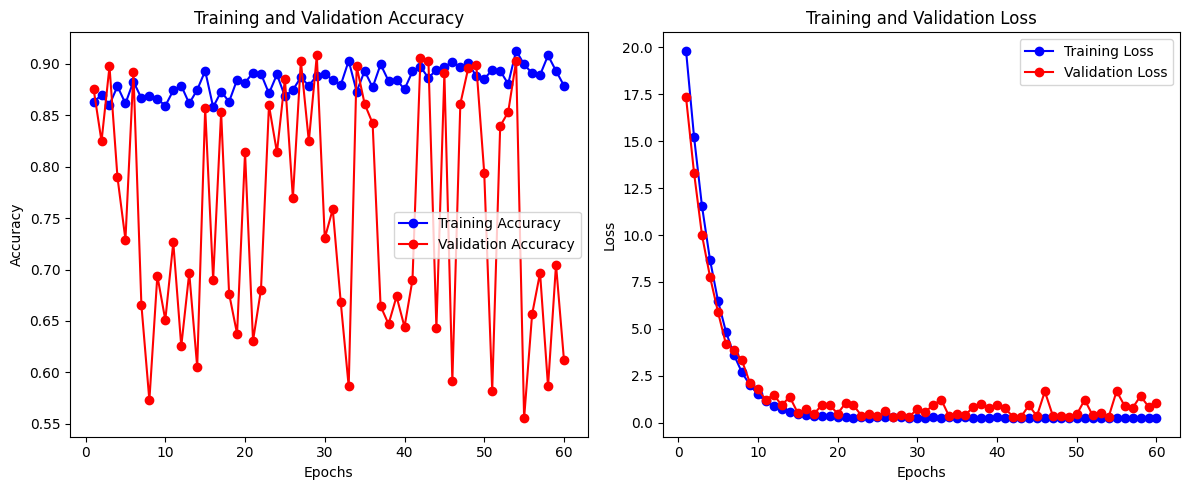

In [20]:
import matplotlib.pyplot as plt

# 提取历史数据
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 绘制 accuracy 和 val_accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制 loss 和 val_loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


真实场景误别效果奇差， 甚至远不如vgg16 原因未知。